## Telecom Customer Churn prediction model



problem statement

goal

null and alternative hypothesis

analytical questions

project timelines


Overview
Customer churn is a major problem and one of the most important concerns for large companies. 
Due to the direct effect on the revenues of the companies, especially in the telecom field, companies are seeking to develop means to predict potential customer to churn.
Therefore, finding factors that increase customer churn is important to take necessary actions to reduce this churn. The main contribution of our work is to develop a churn prediction model which assists telecom operators to predict customers who are most likely subject to churn. The model developed in this work uses machine learning techniques on big data platform and builds a new way of features’ engineering and selection.Customer retention and customer satisfaction are essential for a business to succeed. Customer satisfaction is improved by repeating businesses, brand loyalty, and positive word of mouth.Consumers prefer to stay with their current providers due to quality and price. Therefore, new anti-churn strategies must be constantly developed. Data processing automates analytical model building. Machine learning algorithms improve the dataset iteratively to find hidden patterns. Several studies show that machine learning can predict churn and severe problems in competitive service sectors. Predicting churning customers early on can be a valuable revenue source. 



Null hypothesis :
    1. There is a dominant attribute that affects churn
    2. The customer is not likely to churn
 
    Alternative hypothesis:
    1. There is no dominant attribute that affects churn
    2. The customer is  likely to churn
 
   ### Analytical questions
 
    1.What is the total churn rate?
    2.How does the different boolean attributes affect the churn?
    3.How does the different non-boolean attributes affect the churn?
    4.How does the different numerical attributes affect the churn?
    5. How does tenure affect the churn?
    6.How does the type of internet service affect churn?
    7.How does the type of contract affect the churn?
    8.How does the type of payment method affect the churn?



In [47]:
import pyodbc
from dotenv import dotenv_values  #import the dotenv_values function from the dotenv package
import pandas as pd
import warnings
import io
import requests
 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
warnings.filterwarnings('ignore')

In [16]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")




In [17]:
#creating a connection sring to the SQL  database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [18]:
connection = pyodbc.connect(connection_string)

In [19]:
query = "Select * from dbo.LP2_Telco_churn_first_3000"

data1 = pd.read_sql(query, connection)

In [20]:
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [21]:
url = 'https://raw.github.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv'
download = requests.get(url).content
data2 = pd.read_csv(io.StringIO(download.decode('utf-8')))
data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [22]:
data3 = pd.read_excel("C:\\Users\KEMUNTO\Downloads\Telco-churn-last-2000.xlsx")



In [23]:
training_data = pd.concat([data1, data2], axis=0,ignore_index=True)
training_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.6,Yes


In [28]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [30]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [25]:
training_data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [29]:
training_data.duplicated().sum()

0

In [26]:
training_data.to_csv('train_data.csv')

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>, <Axes: >]],
      dtype=object)

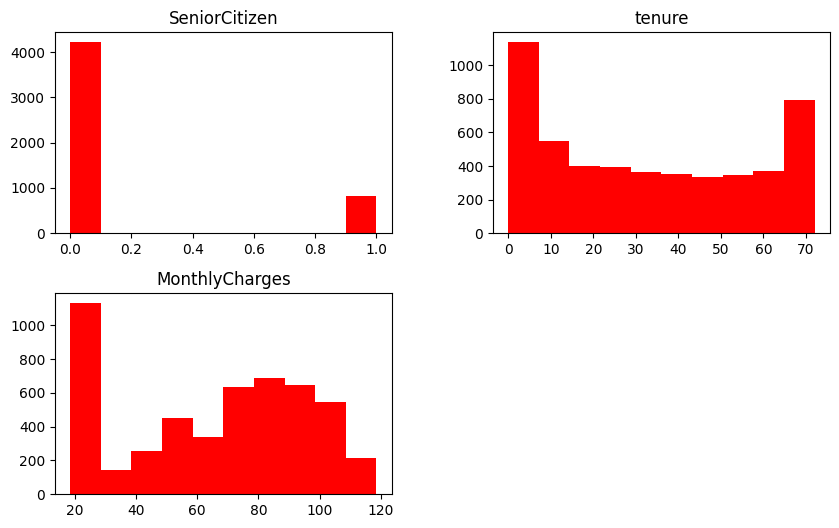

In [35]:
training_data.hist(figsize=(10,6),grid=False, color='red')

<Axes: ylabel='Density'>

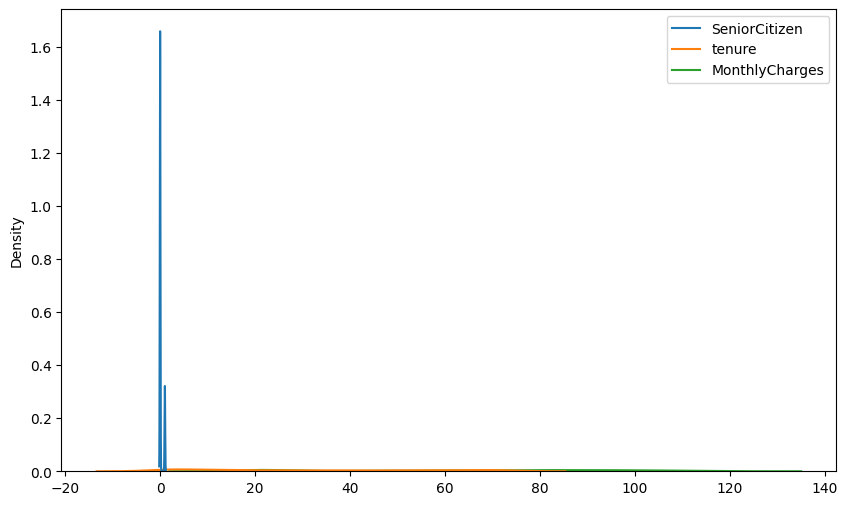

In [40]:
#density distribution
plt.figure(figsize=(10,6))
sns.kdeplot(training_data)

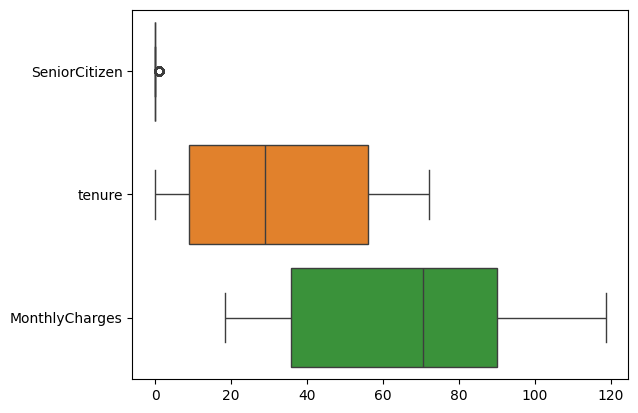

In [44]:
#checking outliers
sns.boxplot(training_data, orient='h')
plt.show()


In [49]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


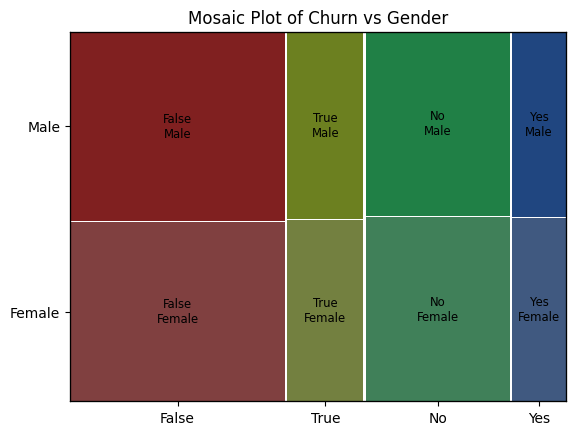

In [52]:
mosaic(training_data, ['Churn', 'gender'], title='Mosaic Plot of Churn vs Gender')
plt.show()

If the tiles for churn and non-churn are of similar size within each gender category, it suggests that churn rates are similar across genders.
If there's a noticeable difference in tile sizes between genders, it suggests that churn rates differ significantly between male and female customers.
If the tile for churn is much larger than the tile for non-churn within a gender category, it indicates a higher churn rate for that gender.
Conversely, if the tile for non-churn is much larger, it indicates a lower churn rate for that gender.

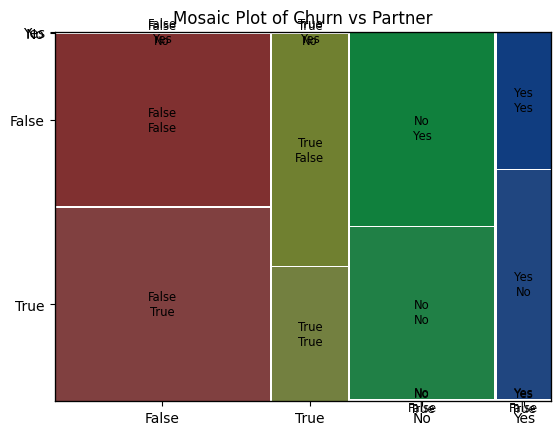

In [54]:
mosaic(training_data, ['Churn', 'Partner'], title='Mosaic Plot of Churn vs Partner')
plt.show()